In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
maxLengths = [20,55,148,403,1097,2981,2000000] #may need to update largest length
data_dir_clueweb = path.join("Data", "clueweb")
data_dir_wikt = path.join("Data", "wikt")

MAKERS = ["o","^","s","*","d", "P", "X"]
markers = itertools.cycle(MARKERS)

## nERR

### Preparing data

In [2]:
#Initialise data dictionary with column names and empty lists
data = {"maxLength" : [], "stemmer" : [], "QID" : [], "nERR" : []}
data_avg = {"maxLength" : [], "stemmer" : [], "nERR" : []}
QID = np.arange(201,301)
for length in maxLengths:
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_clueweb,f"documentLength/nERR-{length}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 100:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nERR"].extend(values[100*i:100*(i+1)])
        data["maxLength"].extend([length for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nERR"].extend(values_avg)
    data_avg["maxLength"].extend([length for _ in labels])
    data_avg["stemmer"].extend(labels)
nERR_length = pd.DataFrame(data)
nERR_length_avg = pd.DataFrame(data_avg)
# display(nERR_length)
# display(nERR_length_avg)

### Average nERR-IA

In [24]:
# target_data = nERR_length_avg[nERR_length_avg["maxLength"] < 100000]
target_data = nERR_length_avg

best_nERR = list()
for length in np.unique(target_data["maxLength"]):
    selected_data = nERR_length_avg[nERR_length_avg["maxLength"] == length]
    best_nERR.append(selected_data["nERR"].max())

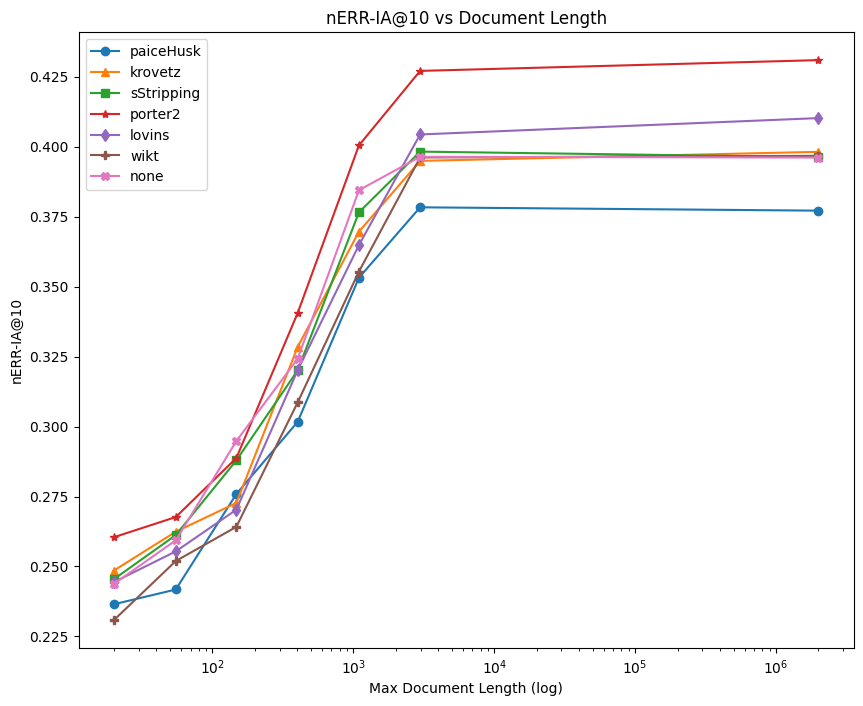

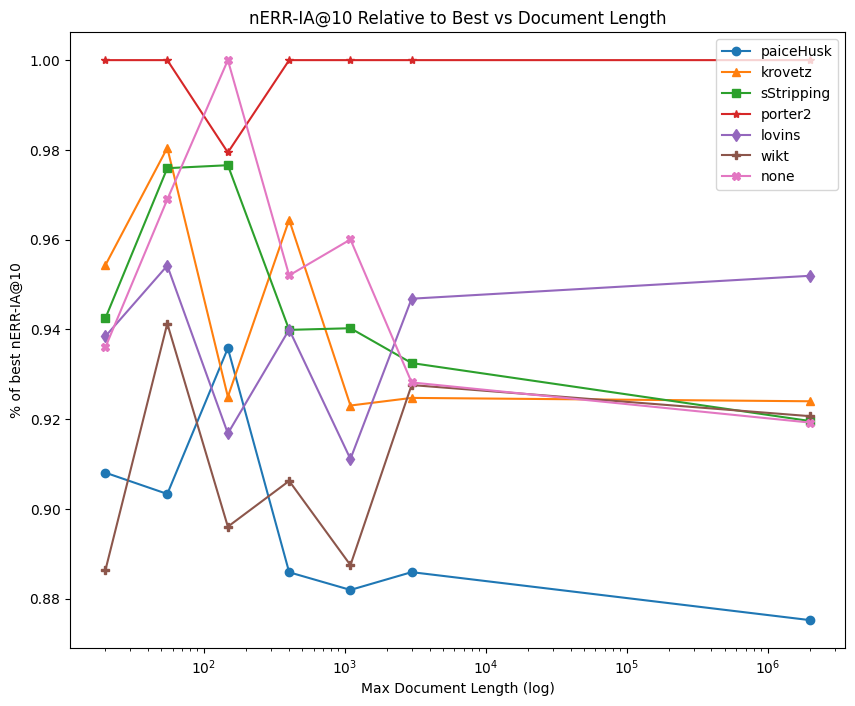

In [25]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["nERR"], marker=next(markers), label=stemmer)
    plt.xscale("log")

plt.title("nERR-IA@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("nERR-IA@10")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nERR"])/best_nERR
    plt.plot(stemmer_data["maxLength"], stemmer_values, marker=next(markers), label=stemmer)
    plt.xscale("log")

plt.title("nERR-IA@10 Relative to Best vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("% of best nERR-IA@10")
plt.legend()

### Results per query

In [ ]:
length = 403
nERR = nERR_length[nERR_length["maxLength"] == length]
# for q in QID:
#     q_nERR = nERR[nERR["QID"] == q]
#     # print(f"Query ID: {q}")
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].max()])
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].min()])
#     display(q_nERR[q_nERR["stemmer"] == "none"])
#     display(q_nERR[q_nERR["stemmer"] == "wikt"])
#     print()

display(nERR[nERR["QID"] == 232])
    

### Statistical Significance

In [6]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
for length in maxLengths:
    p = list()
    n = list()
    target_data = nERR_length[nERR_length["maxLength"] == length]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nERR"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(p,n)}")


Max length: 20 TtestResult(statistic=1.5351538781130707, pvalue=0.12793584097706537, df=99)
Max length: 55 TtestResult(statistic=0.5844332440726641, pvalue=0.5602583377569749, df=99)
Max length: 148 TtestResult(statistic=-0.36463096179656634, pvalue=0.7161646203687981, df=99)
Max length: 403 TtestResult(statistic=0.9660245360073892, pvalue=0.3363858357150723, df=99)
Max length: 1097 TtestResult(statistic=0.9623537615142068, pvalue=0.33821663256154044, df=99)
Max length: 2981 TtestResult(statistic=1.6408299810427383, pvalue=0.1040061608648088, df=99)
Max length: 2000000 TtestResult(statistic=1.9082598712621732, pvalue=0.05925472738235057, df=99)


In [7]:
#t-test between the paiceHusk stemmer (one of the lowest performing) and no stemming
for length in maxLengths:
    s = list()
    n = list()
    target_data = nERR_length[nERR_length["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nERR"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(s,n)}")


Max length: 20 TtestResult(statistic=-0.6860285647782437, pvalue=0.49429860145101223, df=99)
Max length: 55 TtestResult(statistic=-1.218482371384419, pvalue=0.22593644365382753, df=99)
Max length: 148 TtestResult(statistic=-1.4290386274241051, pvalue=0.1561409044550033, df=99)
Max length: 403 TtestResult(statistic=-1.4233273405678595, pvalue=0.15778512768696884, df=99)
Max length: 1097 TtestResult(statistic=-1.78678941554464, pvalue=0.07703222361423603, df=99)
Max length: 2981 TtestResult(statistic=-0.84133670395018, pvalue=0.4021869749977909, df=99)
Max length: 2000000 TtestResult(statistic=-0.8795050845026087, pvalue=0.3812573396618463, df=99)


In [8]:
#t-test between the porter2 and paiceHusk
for length in maxLengths:
    s = list()
    n = list()
    target_data = nERR_length[nERR_length["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"nERR"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(s,n)}")


Max length: 20 TtestResult(statistic=1.9961579762585564, pvalue=0.04866326019494066, df=99)
Max length: 55 TtestResult(statistic=1.9298067018046101, pvalue=0.05649321724780649, df=99)
Max length: 148 TtestResult(statistic=1.0117380118251214, pvalue=0.3141297006734086, df=99)
Max length: 403 TtestResult(statistic=2.566215268992401, pvalue=0.011779649989908833, df=99)
Max length: 1097 TtestResult(statistic=2.7414470780504434, pvalue=0.007259323946320552, df=99)
Max length: 2981 TtestResult(statistic=2.4443090501863542, pvalue=0.016281453964997514, df=99)
Max length: 2000000 TtestResult(statistic=2.687103511551847, pvalue=0.008455103325683838, df=99)


### Linguistic Accuracy

In [10]:
nERR_fmeasure = nERR_length_avg[nERR_length_avg["stemmer"] != "none"]
nERR_fmeasure = nERR_fmeasure[nERR_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for length in maxLengths:
    fmeasures.extend(averages)
nERR_fmeasure = nERR_fmeasure.assign(fmeasure=fmeasures)

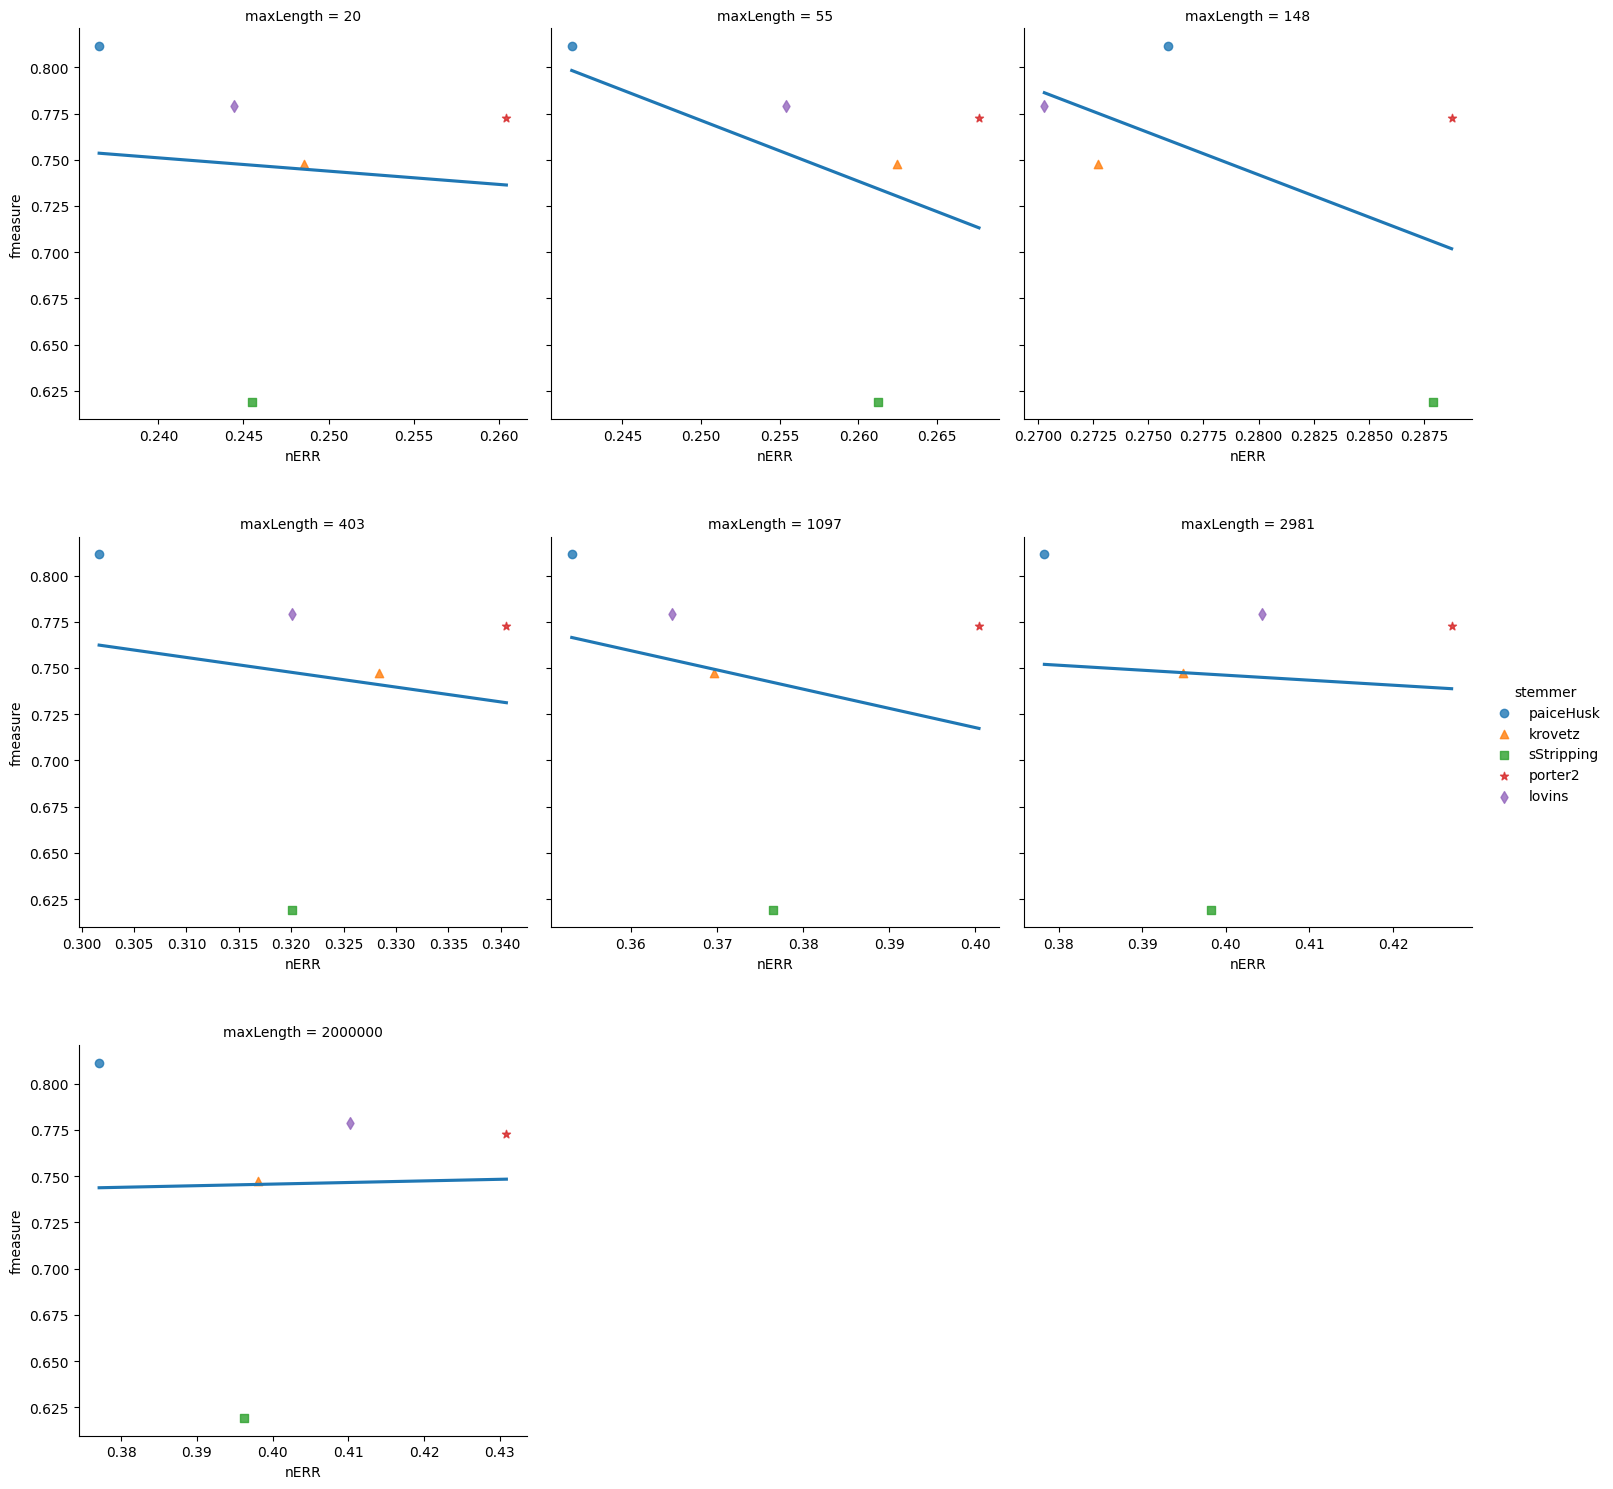

In [17]:
graph = sns.lmplot(nERR_fmeasure, x="nERR", y="fmeasure", hue="stemmer", markers=MARKERS[:-2], col="maxLength", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for document_length, ax in zip(np.unique(nERR_length_avg["maxLength"]), graph.axes):
    target_data = nERR_fmeasure[nERR_fmeasure["maxLength"] == document_length]
    sns.regplot(target_data, x="nERR", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [19]:
for length in maxLengths:
    x = nERR_fmeasure[nERR_fmeasure["maxLength"] == length]["nERR"].to_numpy()
    y = nERR_fmeasure[nERR_fmeasure["maxLength"] == length]["fmeasure"].to_numpy()
    print(f"Length: {length} {stats.pearsonr(x,y)}")

Length: 20 PearsonRResult(statistic=-0.08392438264747595, pvalue=0.8932697264316889)
Length: 55 PearsonRResult(statistic=-0.4378429089362993, pvalue=0.4608840893149561)
Length: 148 PearsonRResult(statistic=-0.5315412744251986, pvalue=0.3565990666360493)
Length: 403 PearsonRResult(statistic=-0.15283782422760006, pvalue=0.8061611352557025)
Length: 1097 PearsonRResult(statistic=-0.2458023833634437, pvalue=0.6902153805732343)
Length: 2981 PearsonRResult(statistic=-0.06410686343969517, pvalue=0.9184325487014984)
Length: 2000000 PearsonRResult(statistic=0.022985123391418484, pvalue=0.9707370090724877)


## nDCG

### Preparing data

In [26]:
#Initialise data dictionary with column names and empty lists
data = {"maxLength" : [], "stemmer" : [], "QID" : [], "nDCG" : []}
data_avg = {"maxLength" : [], "stemmer" : [], "nDCG" : []}
QID = np.arange(201,301)
for length in maxLengths:
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_clueweb,f"documentLength/nDCG-{length}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 100:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nDCG"].extend(values[100*i:100*(i+1)])
        data["maxLength"].extend([length for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nDCG"].extend(values_avg)
    data_avg["maxLength"].extend([length for _ in labels])
    data_avg["stemmer"].extend(labels)
nDCG_length = pd.DataFrame(data)
nDCG_length_avg = pd.DataFrame(data_avg)
# display(nERR_length)
# display(nERR_length_avg)

### Average nDCG

In [27]:
target_data = nDCG_length_avg

best_nDCG = list()
for length in np.unique(target_data["maxLength"]):
    selected_data = nDCG_length_avg[nDCG_length_avg["maxLength"] == length]
    best_nDCG.append(selected_data["nDCG"].max())

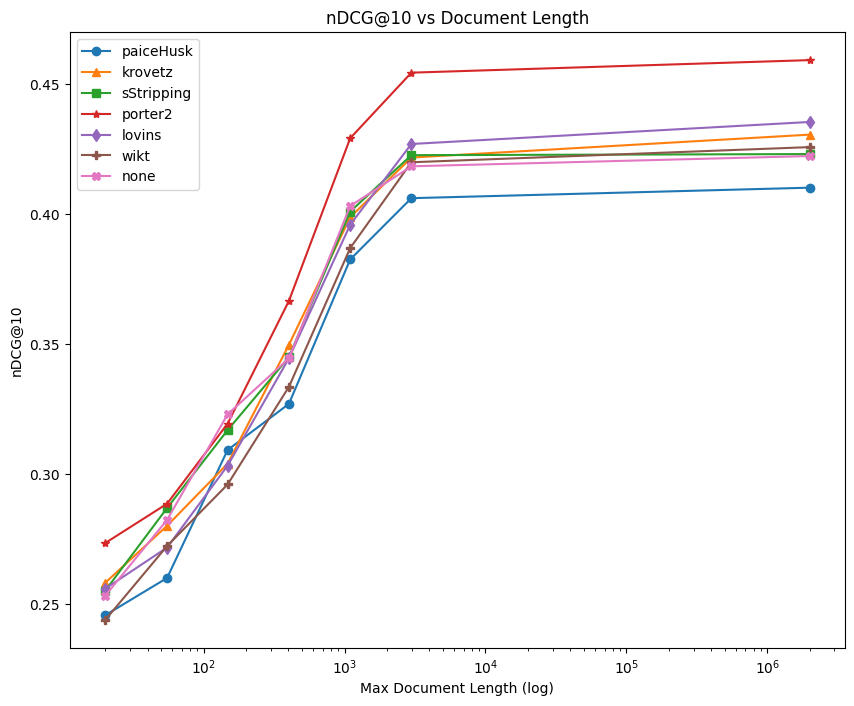

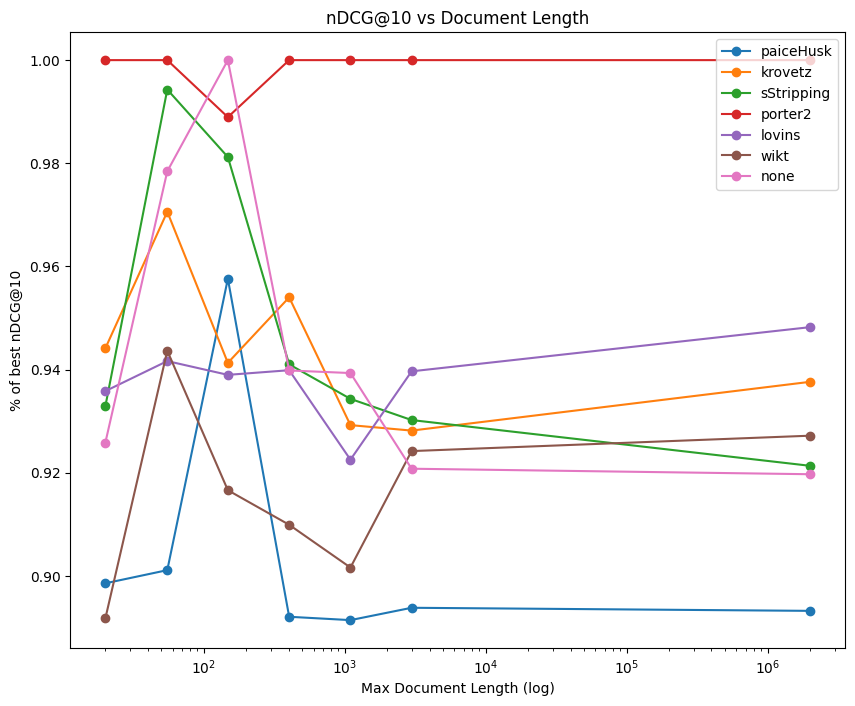

In [28]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["nDCG"], marker=next(markers), label=stemmer)
    plt.xscale("log")

plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("nDCG@10")
plt.legend()
plt.show()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nDCG"])/best_nDCG
    plt.plot(stemmer_data["maxLength"], stemmer_values, "o-", label=stemmer)
    plt.xscale("log")
plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("% of best nDCG@10")
plt.legend()
plt.show()

In [29]:
target_data = nDCG_length_avg[nDCG_length_avg["maxLength"] < 100000]
best_nDCG = list()
for length in np.unique(target_data["maxLength"]):
    selected_data = nDCG_length_avg[nDCG_length_avg["maxLength"] == length]
    best_nDCG.append(selected_data["nDCG"].max())

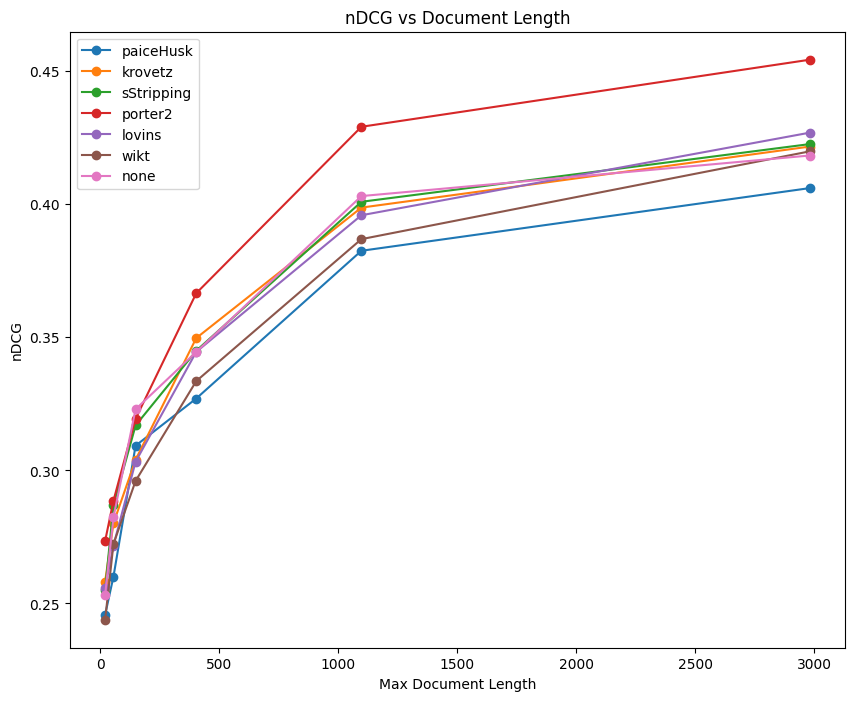

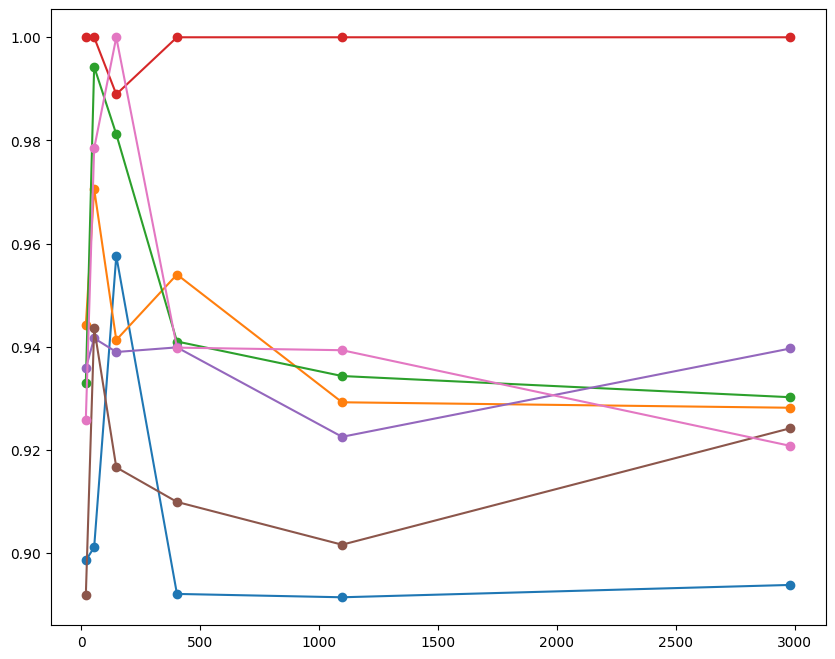

In [20]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["nDCG"], "o-", label=stemmer)
    # plt.xscale("log")

plt.title("nDCG vs Document Length")
plt.xlabel("Max Document Length")
plt.ylabel("nDCG")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nDCG"])/best_nDCG
    plt.plot(stemmer_data["maxLength"], stemmer_values, "o-", label=stemmer)
    # plt.xscale("log")

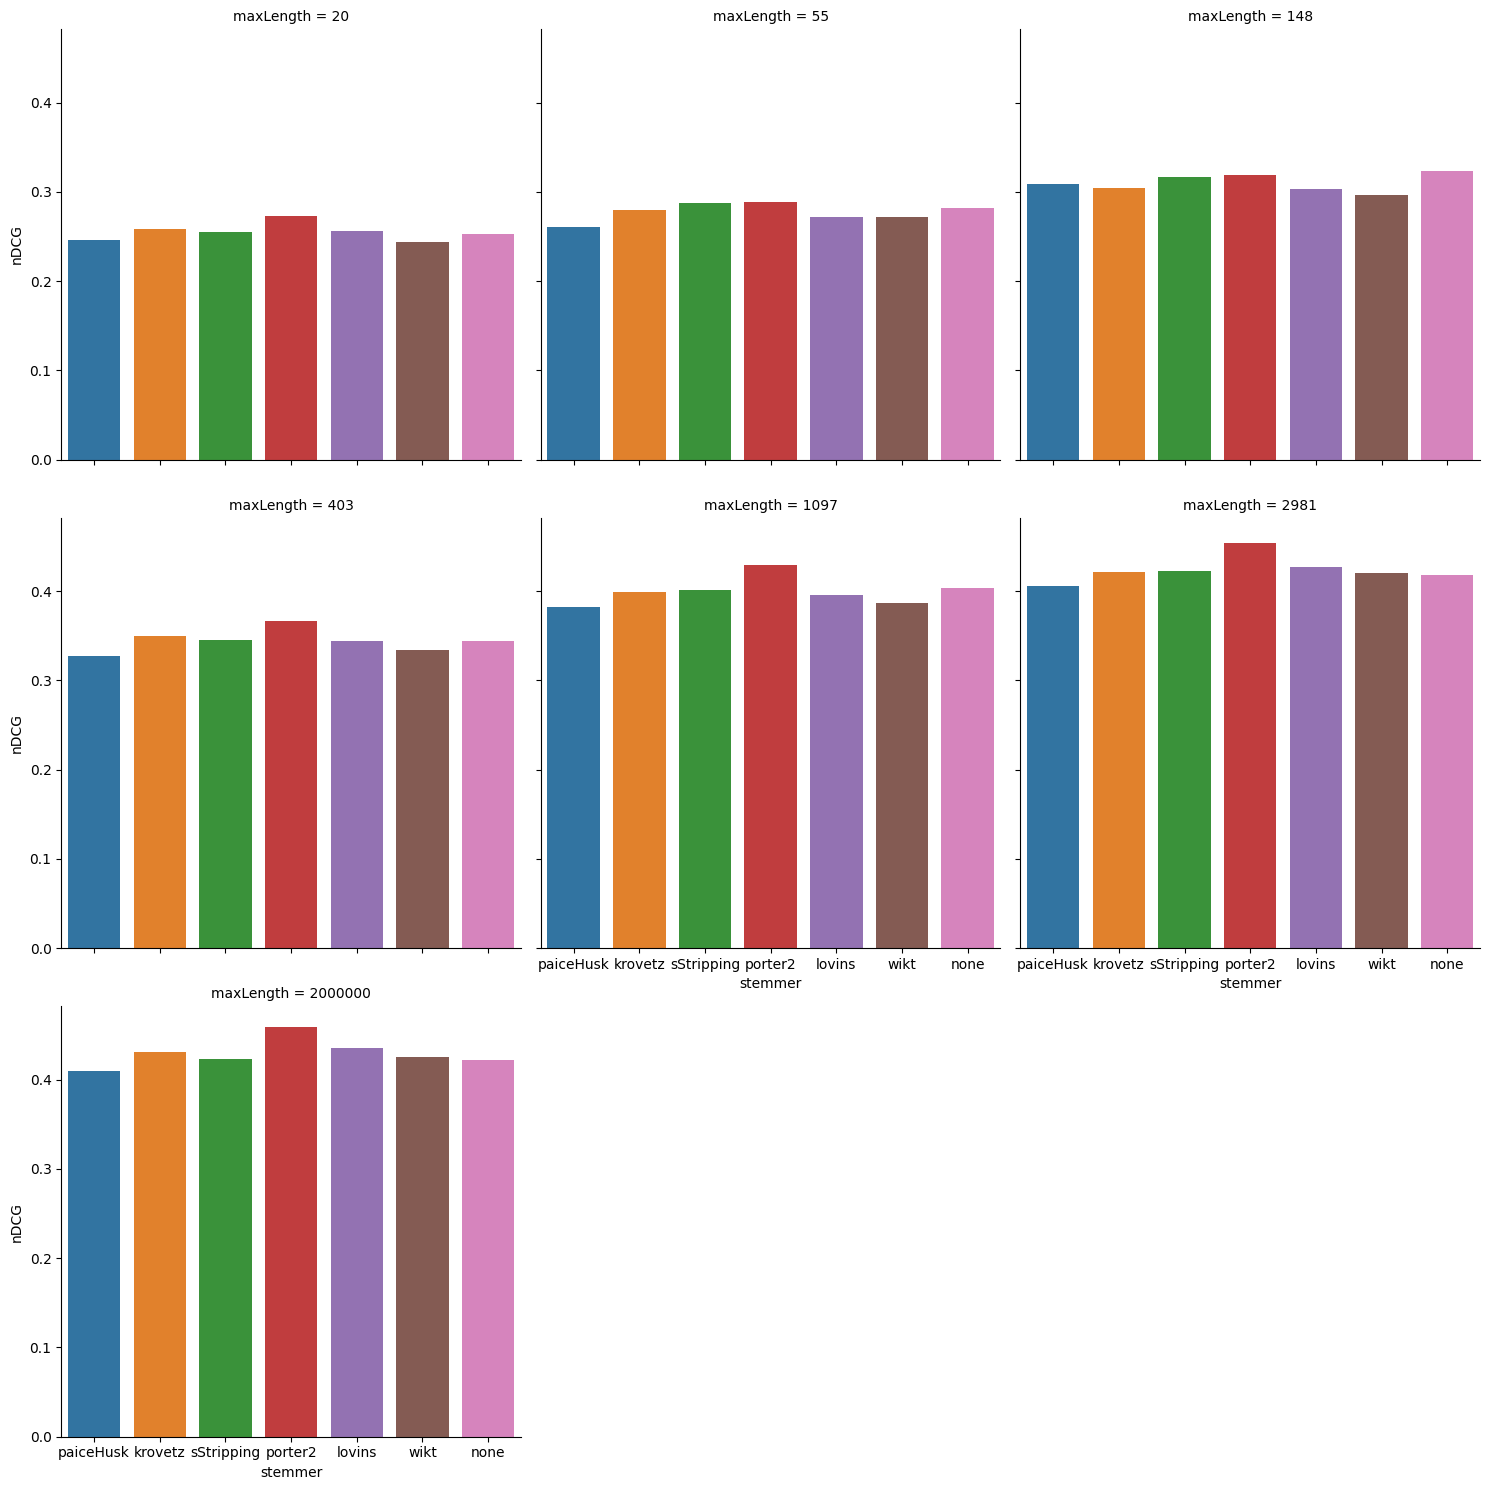

In [26]:
sns.catplot(data=nDCG_length_avg, kind="bar", x="stemmer", y="nDCG", col="maxLength", col_wrap=3)
plt.show()

### Statistical Significance

In [30]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
for length in maxLengths:
    p = list()
    n = list()
    target_data = nDCG_length[nDCG_length["maxLength"] == length]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nDCG"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(p,n)}")


Max length: 20 TtestResult(statistic=1.7082414275907938, pvalue=0.09072531142390064, df=99)
Max length: 55 TtestResult(statistic=0.4653007278973282, pvalue=0.6427380281799122, df=99)
Max length: 148 TtestResult(statistic=-0.25194400469965933, pvalue=0.8016066348085332, df=99)
Max length: 403 TtestResult(statistic=1.3009648155270326, pvalue=0.19629036964937194, df=99)
Max length: 1097 TtestResult(statistic=1.6062219122755244, pvalue=0.1114102605558344, df=99)
Max length: 2981 TtestResult(statistic=2.0808955564665355, pvalue=0.040024888296481445, df=99)
Max length: 2000000 TtestResult(statistic=2.153311305272994, pvalue=0.033722834541793444, df=99)


In [29]:
#t-test between the paiceHusk stemmer (one of the worst performing) and no stemming
for length in maxLengths:
    s = list()
    n = list()
    target_data = nDCG_length[nDCG_length["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nDCG"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(s,n)}")

Max length: 20 TtestResult(statistic=-0.6577342713297623, pvalue=0.5122353491563554, df=99)
Max length: 55 TtestResult(statistic=-1.5670497690325913, pvalue=0.12029398556311975, df=99)
Max length: 148 TtestResult(statistic=-1.06940791686191, pvalue=0.2874864061371721, df=99)
Max length: 403 TtestResult(statistic=-1.1820080631662937, pvalue=0.24003383689702962, df=99)
Max length: 1097 TtestResult(statistic=-1.1911768201331887, pvalue=0.23643221564258246, df=99)
Max length: 2981 TtestResult(statistic=-0.6007540077687, pvalue=0.54937676183149, df=99)
Max length: 2000000 TtestResult(statistic=-0.6119790202842499, pvalue=0.5419545913379433, df=99)


In [31]:
#t-test between the porter2 and paicehusk
for length in maxLengths:
    s = list()
    n = list()
    target_data = nDCG_length[nDCG_length["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"nDCG"].tolist()
    print(f"Max length: {length} {stats.ttest_rel(s,n)}")

Max length: 20 TtestResult(statistic=2.2062936227014394, pvalue=0.029675338510151174, df=99)
Max length: 55 TtestResult(statistic=2.061785904954493, pvalue=0.041848228035688835, df=99)
Max length: 148 TtestResult(statistic=0.9174652560688731, pvalue=0.3611285968179665, df=99)
Max length: 403 TtestResult(statistic=2.695094377022893, pvalue=0.00826872785567508, df=99)
Max length: 1097 TtestResult(statistic=2.745527363298229, pvalue=0.007176077213702953, df=99)
Max length: 2981 TtestResult(statistic=2.640204245053883, pvalue=0.009627922347418546, df=99)
Max length: 2000000 TtestResult(statistic=2.6301720068470575, pvalue=0.009897167595912582, df=99)


### Linguistic Accuracy

In [32]:
nDCG_fmeasure = nDCG_length_avg[nDCG_length_avg["stemmer"] != "none"]
nDCG_fmeasure = nDCG_fmeasure[nDCG_fmeasure["stemmer"] != "wikt"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
fmeasures = list()
for length in maxLengths:
    fmeasures.extend(averages)
nDCG_fmeasure = nDCG_fmeasure.assign(fmeasure=fmeasures)

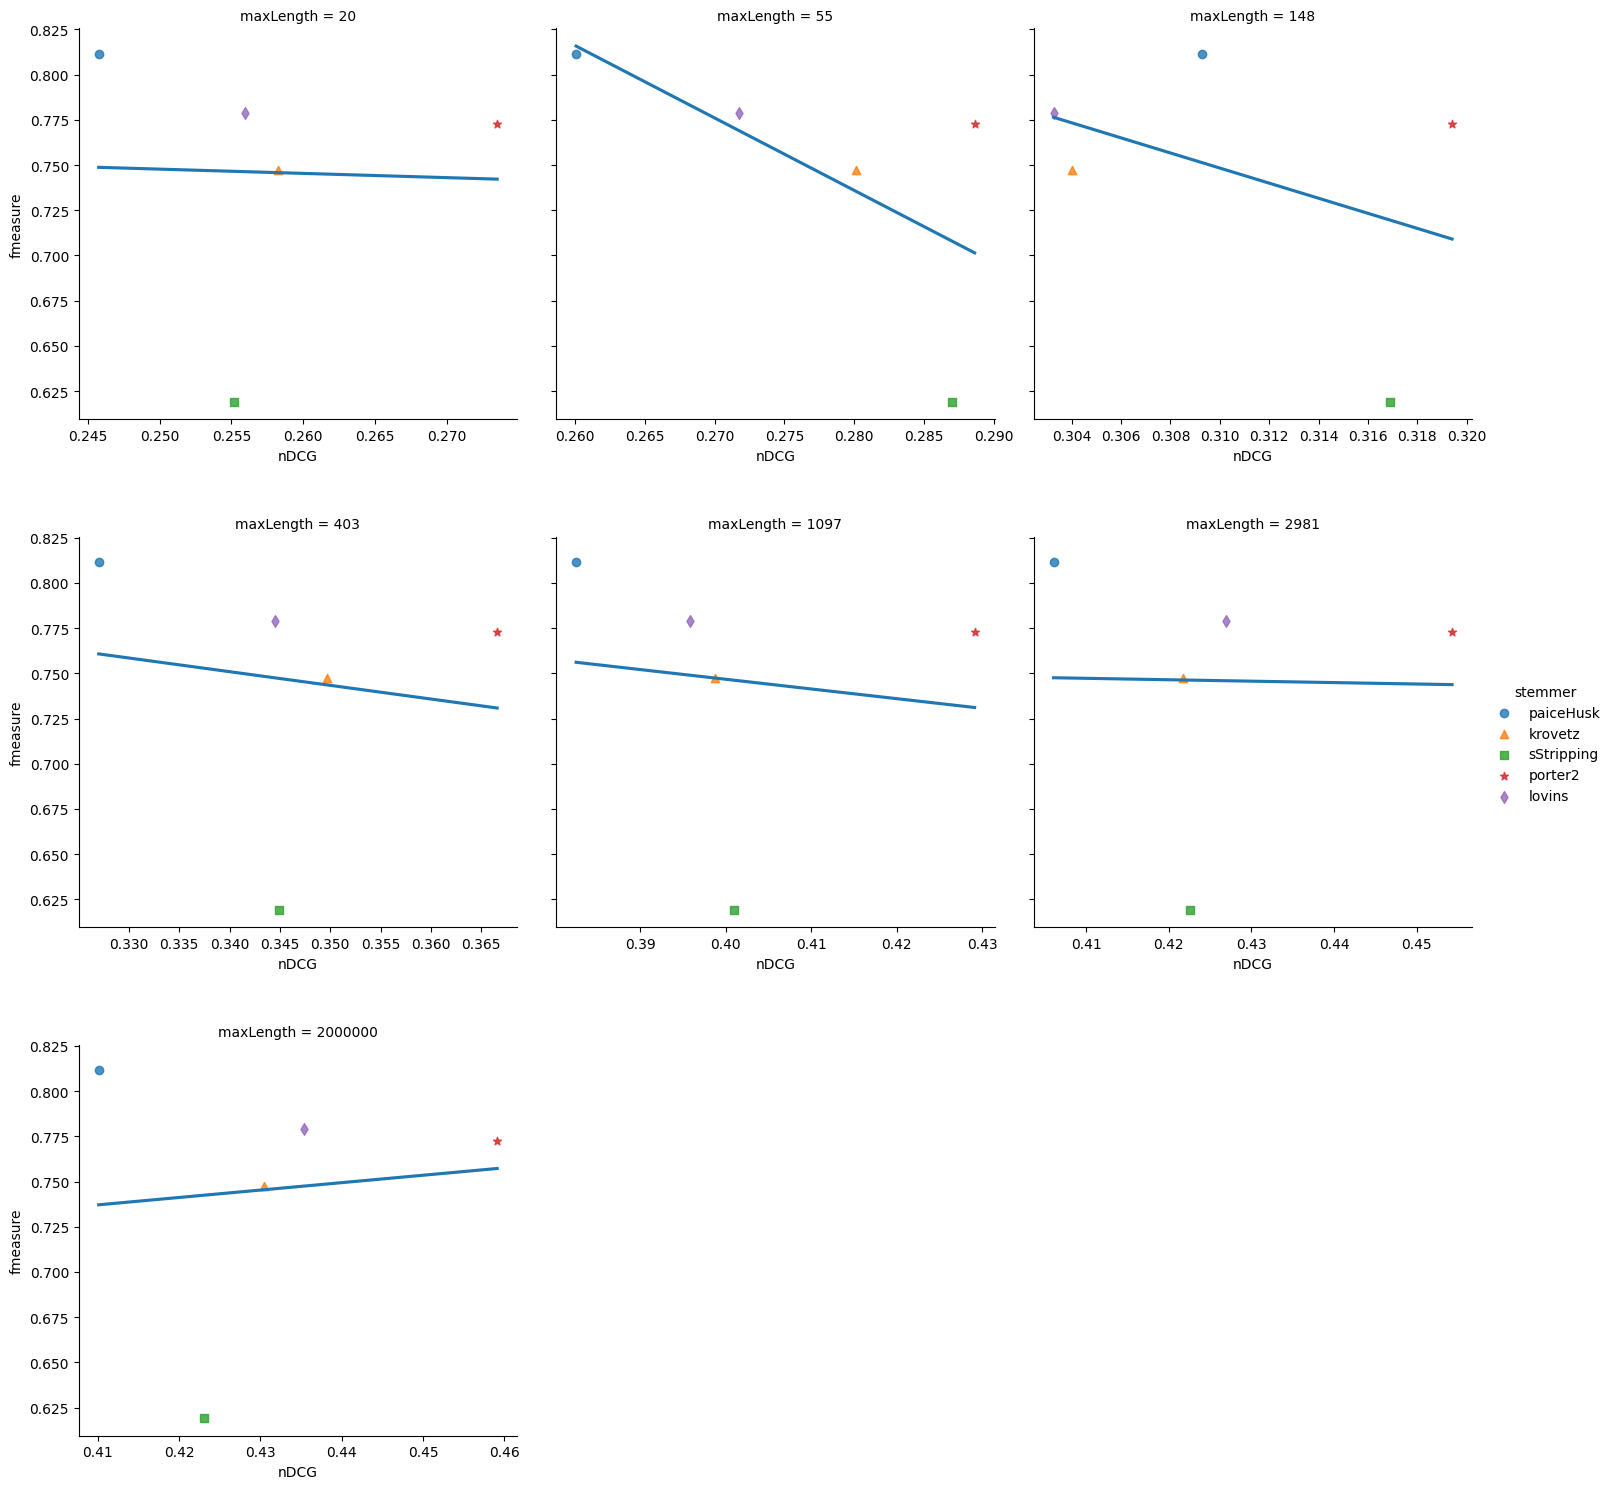

In [33]:
graph = sns.lmplot(nDCG_fmeasure, x="nDCG", y="fmeasure", hue="stemmer", markers=MARKERS[:-2], col="maxLength", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for document_length, ax in zip(np.unique(nDCG_length_avg["maxLength"]), graph.axes):
    target_data = nDCG_fmeasure[nDCG_fmeasure["maxLength"] == document_length]
    sns.regplot(target_data, x="nDCG", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [34]:
for length in maxLengths:
    x = nDCG_fmeasure[nDCG_fmeasure["maxLength"] == length]["nDCG"].to_numpy()
    y = nDCG_fmeasure[nDCG_fmeasure["maxLength"] == length]["fmeasure"].to_numpy()
    print(f"Length: {length} {stats.pearsonr(x,y)}")

Length: 20 PearsonRResult(statistic=-0.03171696098244496, pvalue=0.9596234827603718)
Length: 55 PearsonRResult(statistic=-0.6350151302646615, pvalue=0.24969451314664243)
Length: 148 PearsonRResult(statistic=-0.4121289701147618, pvalue=0.4905191229288101)
Length: 403 PearsonRResult(statistic=-0.14374012810476103, pvalue=0.8176165735784671)
Length: 1097 PearsonRResult(statistic=-0.12293062589135723, pvalue=0.8438749847776165)
Length: 2981 PearsonRResult(statistic=-0.01852258043800918, pvalue=0.9764176667236559)
Length: 2000000 PearsonRResult(statistic=0.09959554743127533, pvalue=0.8734009657316925)
